In [1]:
!pip install kaggle

In [5]:
!mkdir "%USERPROFILE%\\.kaggle"
!copy kaggle.json "%USERPROFILE%\\.kaggle\\"
!icacls "%USERPROFILE%\\.kaggle\\kaggle.json" /inheritance:r /grant:r "%USERNAME%:RW"

A subdirectory or file C:\Users\hp\\.kaggle already exists.


        1 file(s) copied.
processed file: C:\Users\hp\\.kaggle\\kaggle.json
Successfully processed 1 files; Failed processing 0 files


In [7]:
#  Download Amazon Fine Food Reviews dataset
!kaggle datasets download -d snap/amazon-fine-food-reviews

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0




  0%|          | 0.00/242M [00:00<?, ?B/s]
 19%|#9        | 47.0M/242M [00:00<00:00, 492MB/s]
 39%|###8      | 94.0M/242M [00:00<00:00, 401MB/s]
 55%|#####5    | 134M/242M [00:00<00:00, 342MB/s] 
 69%|######9   | 168M/242M [00:00<00:00, 287MB/s]
 81%|########1 | 197M/242M [00:00<00:00, 284MB/s]
 94%|#########4| 228M/242M [00:00<00:00, 294MB/s]
100%|##########| 242M/242M [00:00<00:00, 314MB/s]


In [1]:
# Extract the dataset
from zipfile import ZipFile
dataset = "amazon-fine-food-reviews.zip"

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print("Dataset is extracted")

Dataset is extracted


In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Print stopwords
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [4]:
# Load the dataset
# The dataset has columns like 'Text' (review) and 'Score' (1-5 stars)
column_names = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 
                'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']
review_data = pd.read_csv("C:/Users/hp/Desktop/python/Amazon Reviews Sentiment Analysis/Reviews.csv", names=column_names, encoding='ISO-8859-1', skiprows=1)

In [5]:
print(review_data.shape)

(568454, 10)


In [6]:
print(review_data.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [7]:
print(review_data.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [8]:
# Convert star ratings to binary sentiment (1-2 = negative, 4-5 = positive, ignore 3)
# Create a new 'target' column
review_data['target'] = review_data['Score'].apply(lambda x: 0 if x <= 2 else 1 if x >= 4 else None)
# Drop rows with neutral (3-star) reviews
review_data = review_data.dropna(subset=['target'])
print(review_data['target'].value_counts())

target
1.0    443777
0.0     82037
Name: count, dtype: int64


In [9]:
# Define stemming function
ps = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-letters
    stemmed_content = stemmed_content.lower()  # Convert to lowercase
    stemmed_content = stemmed_content.split()  # Split into words
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]  # Stem and remove stopwords
    stemmed_content = ' '.join(stemmed_content)  # Join back to string
    return stemmed_content

In [11]:
# Apply stemming to review text (this may take a while due to dataset size)
# Sample 20,000 reviews to reduce processing time
review_data = review_data.sample(n=20000, random_state=2)
print("Sampled dataset shape:", review_data.shape)

Sampled dataset shape: (20000, 11)


In [12]:
# Apply stemming to review text (faster with sampled data)
review_data['stemmed_content'] = review_data['Text'].apply(stemming)


In [13]:
# Save stemmed data
review_data.to_csv('stemmed_reviews.csv', index=False)
print("Stemmed data saved to stemmed_reviews.csv")

Stemmed data saved to stemmed_reviews.csv


In [14]:
review_data = pd.read_csv('stemmed_reviews.csv')

In [15]:
# View processed data
print(review_data[['Text', 'stemmed_content', 'target']].head())

                                                Text  \
0  My dogs, Storm (Blue Weimaraner 20 months) and...   
1  These are the best bones around ...it's a two ...   
2  This is a great snack - made even greater with...   
3  I always get this candy when I go to the store...   
4  I really wanted my little shihtzu, Sheldon, to...   

                                     stemmed_content  target  
0  dog storm blue weimaran month riley dalmatian ...     1.0  
1  best bone around two one treat bone chew meati...     1.0  
2  great snack made even greater free ship discou...     1.0  
3  alway get candi go store back home find east c...     1.0  
4  realli want littl shihtzu sheldon like food go...     0.0  


In [16]:
# Separate features and labels
X = review_data['stemmed_content'].values
Y = review_data['target'].values

In [17]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [18]:
# Check shapes
print(X.shape, X_train.shape, X_test.shape)

(20000,) (16000,) (4000,)


In [19]:
# Convert text to numerical data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to manage memory
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [21]:
# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [23]:
# Evaluate on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Accuracy on the training data is:", training_data_accuracy)

Accuracy on the training data is: 0.919


In [24]:
# Evaluate on test data
X_test_prediction = model.predict(X_test)
testing_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print("Accuracy on the testing data is:", testing_data_accuracy)

Accuracy on the testing data is: 0.89575


#### MODEL ACCURACY : 89.5%

In [25]:
# Test the model on a sample review
sample_review = "This product is amazing and works perfectly!"
sample_processed = stemming(sample_review)
sample_vectorized = vectorizer.transform([sample_processed])
prediction = model.predict(sample_vectorized)
print("Sample review sentiment:", "Positive" if prediction[0] == 1 else "Negative")

Sample review sentiment: Positive


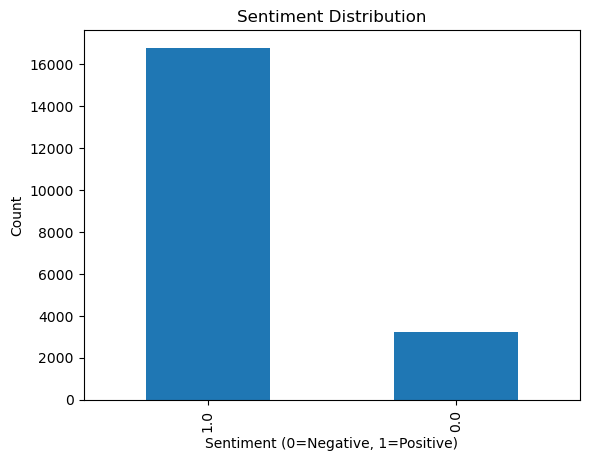

In [26]:
import matplotlib.pyplot as plt
review_data['target'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()